In [1]:
# ---------------------------------------------------
# 0 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# --------------------------------------------------------------------------
# ==> IMPORTANT: Point this to the directory containing your CSV files <==
# --------------------------------------------------------------------------
# The path below is a placeholder from your script.
# You MUST update it to the correct location on your computer.
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"

# If you don't want to use a folder, you can hard-code the list of file paths:
# csv_files = ["path/to/your/file1.csv", "path/to/your/file2.csv"]

try:
    csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))
    if not csv_files:
        raise FileNotFoundError("csv_files list is empty – check the 'raw_dir' path.")
except FileNotFoundError as e:
    print(e)
    # As a fallback for demonstration, create a dummy dataframe
    print("Creating a sample DataFrame for demonstration purposes.")
    df = pd.DataFrame({
        'age': np.random.randint(0, 100, 5000),
        'modality': np.random.choice([
            'Computerized axial tomography (procedure)', 'Magnetic resonance imaging (procedure)', 'Endoscopy (procedure)',
            'Plain radiography (procedure)', 'Diagnostic ultrasonography (procedure)', 'Fluoroscopy (procedure)'
        ], size=5000),
        'patient_source': np.random.choice(['accident & emergency department', 'gp direct access service', 'inpatient', 'outpatient', 'elective admission'], size=5000)
    })
else:
    print(f"Detected {len(csv_files)} files to load.")

    # ----------- Canonical 23-column schema from the SQL query ---------------
    expected_cols = [
        'icb_code','icb_name','lsoa_code','nhs_region',
        'site_code','site_name','provider_code','provider_name',
        'activity_month','financial_year','financial_month','test_date',
        'age','sex','modality','sub_modality','procedure_name',
        'referral_type','patient_source','cancer_flag','subcancer_flag',
        'referring_org_code','referring_org_name'
    ]

    dfs, meta = [], []
    for fp in csv_files:
        try:
            peek = pd.read_csv(fp, nrows=5)
            if not set(expected_cols).issubset(peek.columns):
                print(f"'{os.path.basename(fp)}' – no header found, reloading with specified names.")
                df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
            else:
                df_tmp = pd.read_csv(fp, low_memory=False)

            df_tmp = df_tmp.dropna(axis=1, how='all')
            df_tmp.columns = df_tmp.columns.str.strip().str.lower()
            
            # Align to expected schema
            df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
            for col in (set(expected_cols) - set(df_tmp.columns)):
                df_tmp[col] = pd.NA
            df_tmp = df_tmp[expected_cols]
            dfs.append(df_tmp)

            meta.append({
                "file": os.path.basename(fp),
                "rows": len(df_tmp),
                "cols": df_tmp.shape[1],
                "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
            })
        except Exception as e:
            print(f"Error loading file {os.path.basename(fp)}: {e}")


    meta_df = pd.DataFrame(meta)
    display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        print(f"\nCombined shape: {df.shape}")
    else:
        print("\nNo dataframes were loaded. Halting script.")
        # Create a dummy df to prevent further errors
        df = pd.DataFrame(columns=expected_cols)

Detected 7 files to load.
'2024_NHS_SW_Somerset_ICB_11X.csv' – no header found, reloading with specified names.
'2024_NHS_SW_Cornwall_ICB_11N.csv' – no header found, reloading with specified names.
'2024_NHS_SW_Gloucestershire_ICB_11M.csv' – no header found, reloading with specified names.
'2024_NHS_SW_Dorset_ICB_11J.csv' – no header found, reloading with specified names.
'2024_NHS_SW_Devon_ICB_15N.csv' – no header found, reloading with specified names.
'2024_NHS_SW_BSW_ICB_92G.csv' – no header found, reloading with specified names.
'2024_NHS_SW_BNSSG_ICB_15C.csv' – no header found, reloading with specified names.


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000



Combined shape: (3989252, 23)


In [2]:
# --- Basic type coercion and cleaning ---
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)

# --- Standardize 'patient_source' and create 'ps_bucket' ---
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

ps_bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":              "GP",
    r"inpatient":                  "Inpatient",
    r"outpatient":                 "Outpatient",
    r"elective|planned":           "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in ps_bucket_map.items():
        if re.search(pat, txt, re.IGNORECASE):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)
print("\nPatient Source Buckets:")
print(df["ps_bucket"].value_counts(dropna=False))


# =====================================================================
#  ==> NEW: Standardize 'modality' and create 'modality_bucket' <==
# =====================================================================
modality_bucket_map = {
    r"tomography|ct": "CT",
    r"magnetic resonance|mri": "MRI",
    r"endoscopy": "Endoscopy",
    r"radiography": "Radiography",
    r"ultrasonography|ultrasound": "Ultrasound",
    r"fluoroscopy": "Fluoroscopy"
}
def modality_bucket(txt: str) -> str:
    txt = str(txt).lower()
    for pat, lab in modality_bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other"

df["modality_bucket"] = df["modality"].apply(modality_bucket)
print("\nModality Buckets:")
print(df['modality_bucket'].value_counts(dropna=False))


# --- Create ONS-style age bands ---
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]

# Keep only whole-number ages and create 'age_band'
df.dropna(subset=['age'], inplace=True)
df = df[df["age"] % 1 == 0]
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)

# --- Create combined 'em'/'el' elective/emergency source ---
def assign_em_el_source(ps_bucket):
    if ps_bucket in ['Emergency', 'Inpatient']:
        return 'em (Emergency/Inpatient)'
    elif ps_bucket in ['GP', 'Outpatient', 'Elective']:
        return 'el (Elective/GP)'
    else:
        return 'Other/Unknown'

df['patient_source_combined'] = df['ps_bucket'].apply(assign_em_el_source)

print("\nCombined Emergency/Elective Buckets:")
print(df['patient_source_combined'].value_counts(dropna=False))

print("\nFinal DataFrame Head:")
display(df[['age', 'age_band', 'patient_source', 'ps_bucket', 'patient_source_combined', 'modality', 'modality_bucket']].head())


Patient Source Buckets:
ps_bucket
Outpatient       1428095
GP                923522
Emergency         832850
Inpatient         695375
Other/Unknown     109410
Name: count, dtype: int64

Modality Buckets:
modality_bucket
Radiography    1561210
Ultrasound      782314
CT              678020
Other           543096
MRI             324893
Fluoroscopy      92545
Endoscopy         7174
Name: count, dtype: int64

Combined Emergency/Elective Buckets:
patient_source_combined
el (Elective/GP)            2351601
em (Emergency/Inpatient)    1528177
Other/Unknown                109410
Name: count, dtype: int64

Final DataFrame Head:


,age,age_band,patient_source,ps_bucket,patient_source_combined,modality,modality_bucket
0,56,55-59,gp direct access,GP,el (Elective/GP),Diagnostic ultrasonography (procedure),Ultrasound
1,72,70-74,admitted patient care – inpatient,Inpatient,em (Emergency/Inpatient),Plain radiography (procedure),Radiography
2,65,65-69,gp direct access,GP,el (Elective/GP),Plain radiography (procedure),Radiography
3,73,70-74,accident and emergency department,Emergency,em (Emergency/Inpatient),Plain radiography (procedure),Radiography
4,73,70-74,gp direct access,GP,el (Elective/GP),NaN,Other


In [3]:
def plot_modality_usage(df, modality_bucket_name):
    """
    Generates and displays a set of line plots for a given modality bucket.
    Uses 'age_band', 'ps_bucket', and the new 'modality_bucket' columns.
    """
    if df.empty or modality_bucket_name not in df['modality_bucket'].unique():
        print(f"No data found for modality bucket '{modality_bucket_name}'. Skipping plots.")
        return

    modality_df = df[df['modality_bucket'] == modality_bucket_name].copy()
    
    # Define a consistent order for the legend
    source_order = sorted(modality_df['ps_bucket'].unique())
    combined_source_order = sorted(modality_df['patient_source_combined'].unique())

    print(f"--- Generating Plots for {modality_bucket_name} ---")

    # --- Plot 1: Individual Patient Sources ('ps_bucket') ---
    plt.figure(figsize=(14, 8))
    agg_df_individual = modality_df.groupby(['age_band', 'ps_bucket'], as_index=False, observed=True).size()
    sns.lineplot(
        data=agg_df_individual,
        x='age_band',
        y='size',
        hue='ps_bucket',
        hue_order=source_order,
        marker='o'
    )
    plt.title(f'{modality_bucket_name} Usage by Age Band (Split by Patient Source)')
    plt.xlabel('Age Band')
    plt.ylabel('Number of Procedures')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Patient Source')
    plt.tight_layout()
    plt.show()

    # --- Plot 2: All/General Patient Sources ---
    plt.figure(figsize=(14, 8))
    agg_df_all = modality_df.groupby('age_band', as_index=False, observed=True).size()
    sns.lineplot(
        data=agg_df_all,
        x='age_band',
        y='size',
        marker='o',
        label=modality_bucket_name
    )
    plt.title(f'Total {modality_bucket_name} Usage by Age Band (All Sources)')
    plt.xlabel('Age Band')
    plt.ylabel('Number of Procedures')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Combined em/el Patient Sources ---
    plt.figure(figsize=(14, 8))
    agg_df_combined = modality_df.groupby(['age_band', 'patient_source_combined'], as_index=False, observed=True).size()
    sns.lineplot(
        data=agg_df_combined,
        x='age_band',
        y='size',
        hue='patient_source_combined',
        hue_order=combined_source_order,
        marker='o'
    )
    plt.title(f'{modality_bucket_name} Usage by Age Band (Emergency vs. Elective)')
    plt.xlabel('Age Band')
    plt.ylabel('Number of Procedures')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Combined Patient Source')
    plt.tight_layout()
    plt.show()

--- Generating Plots for CT ---


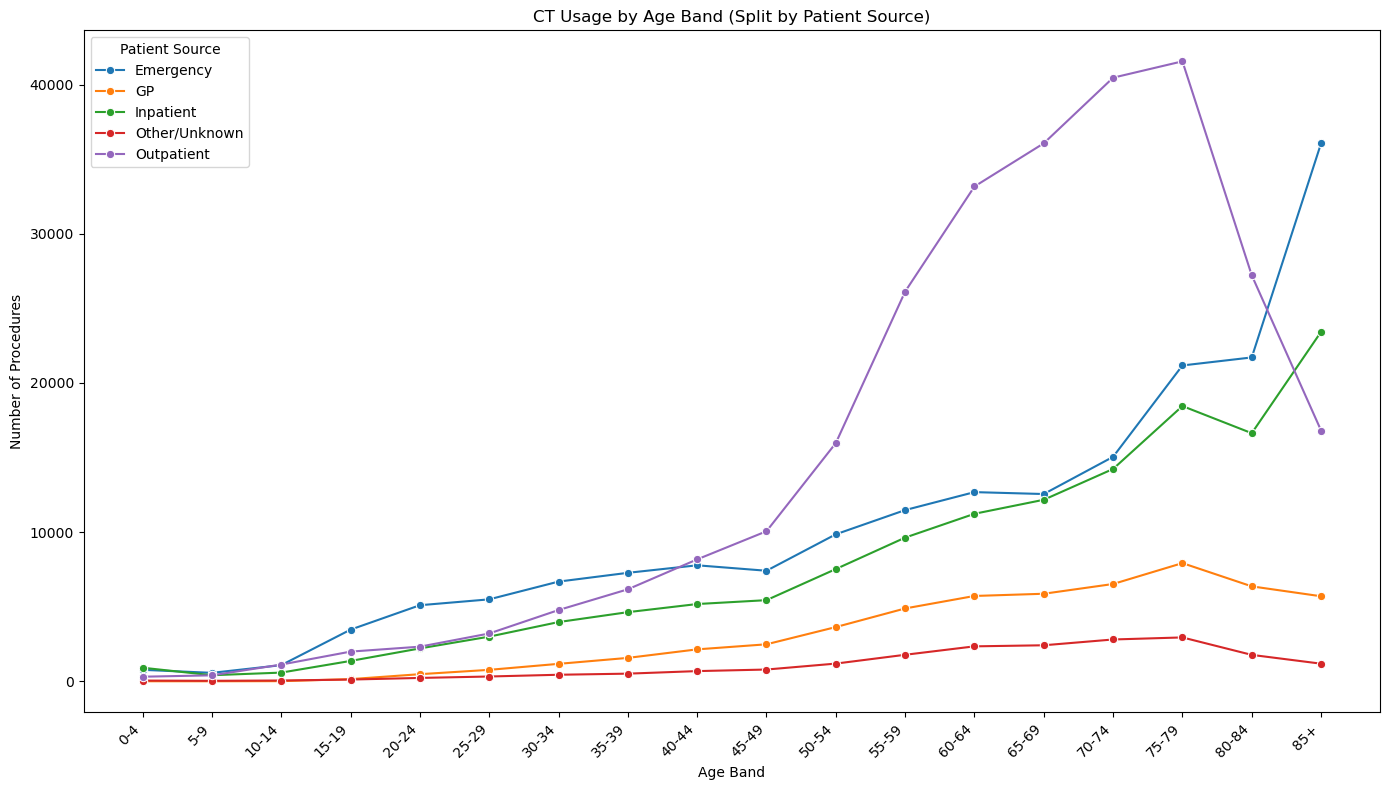

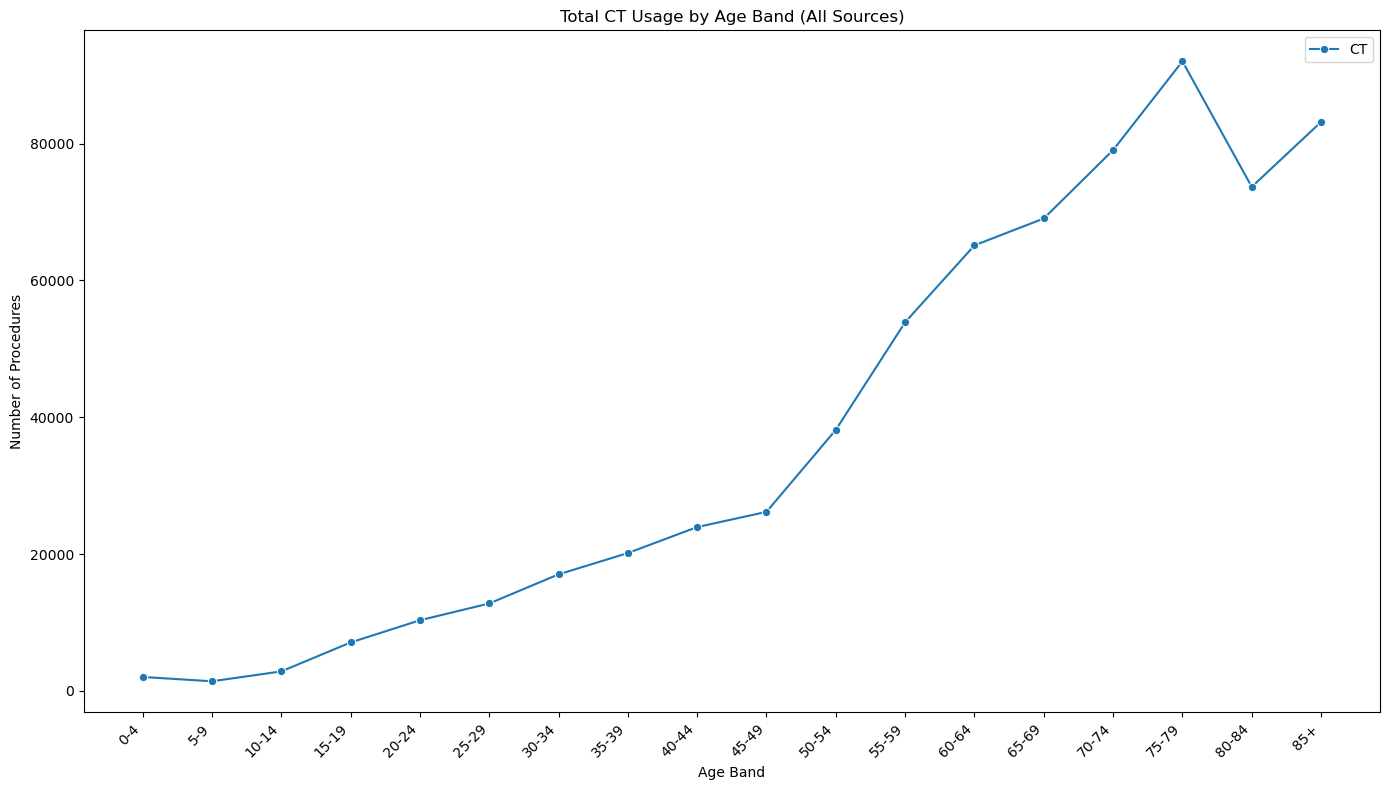

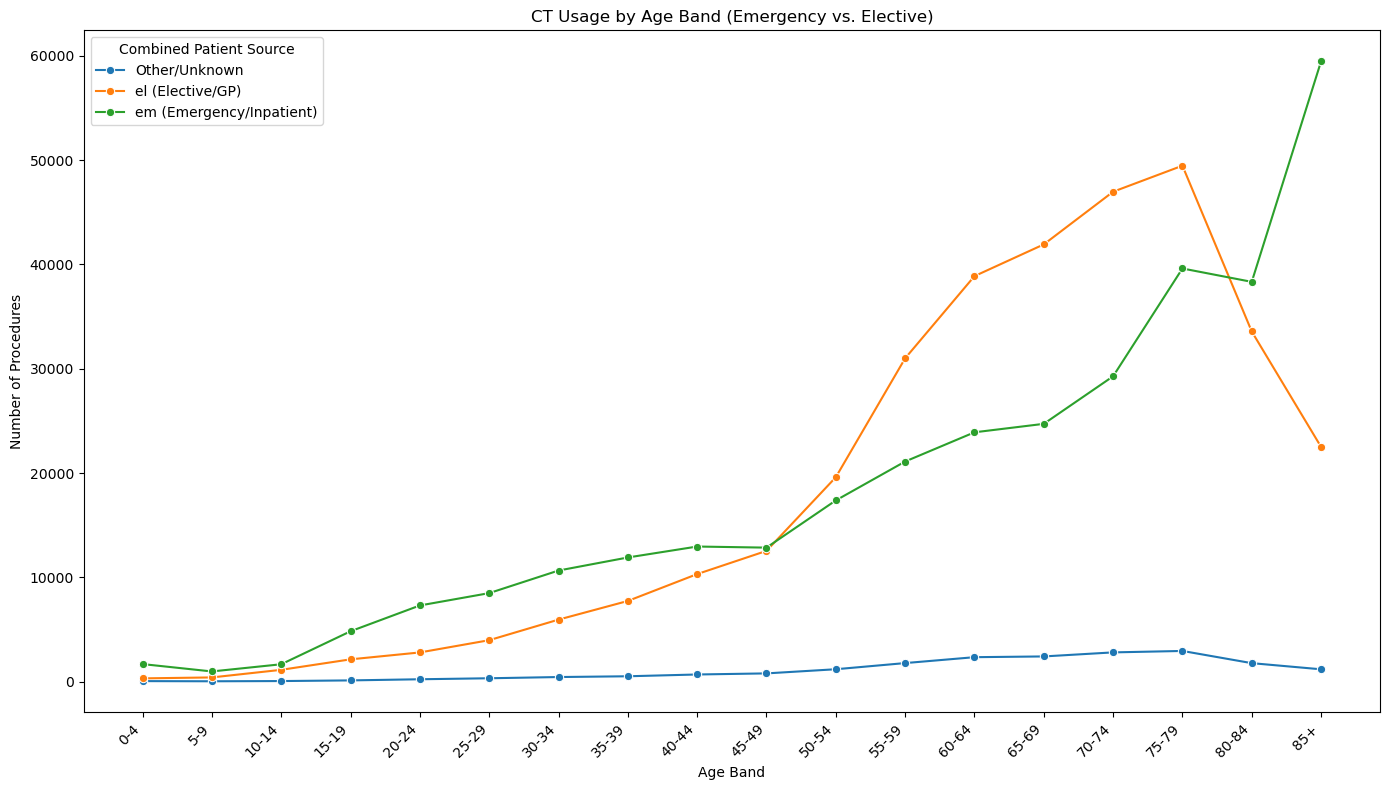

--- Generating Plots for MRI ---


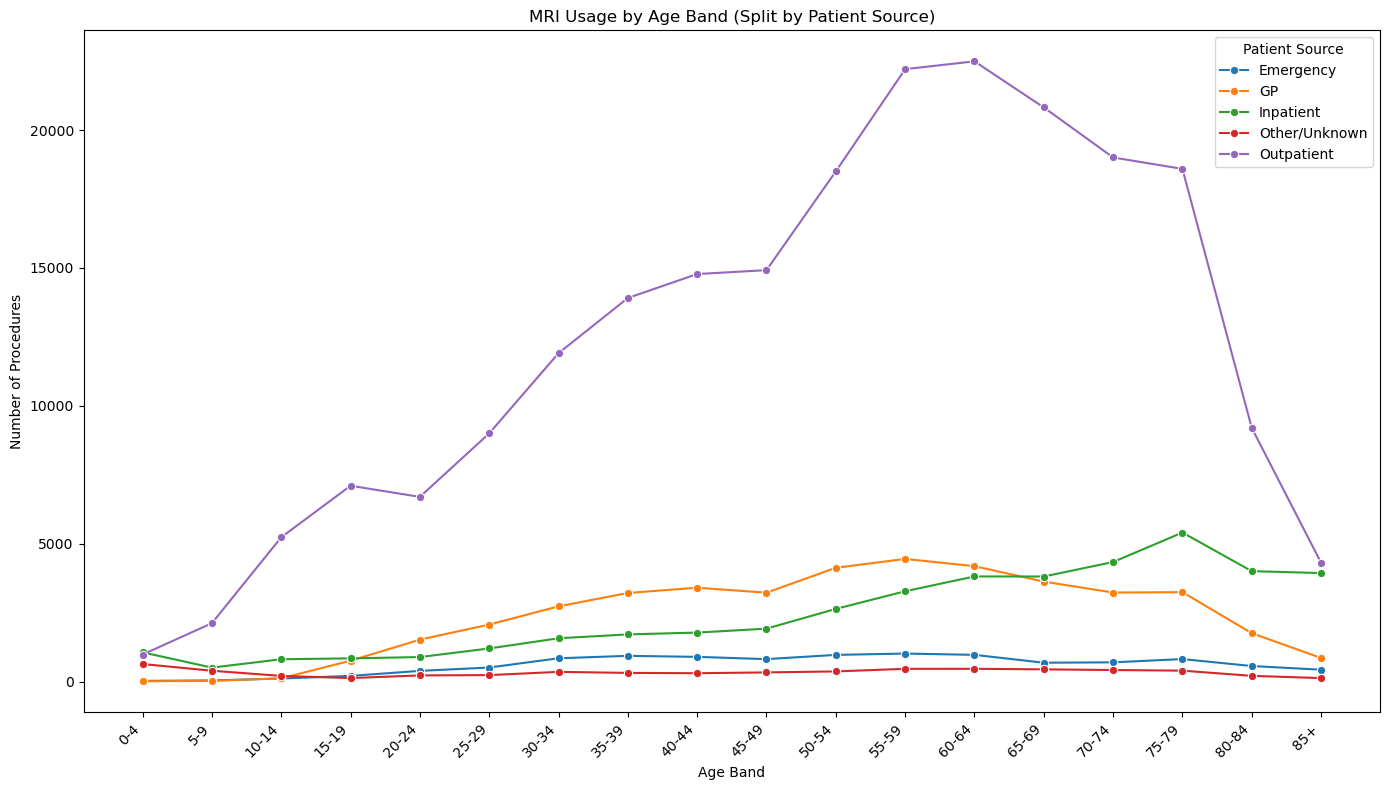

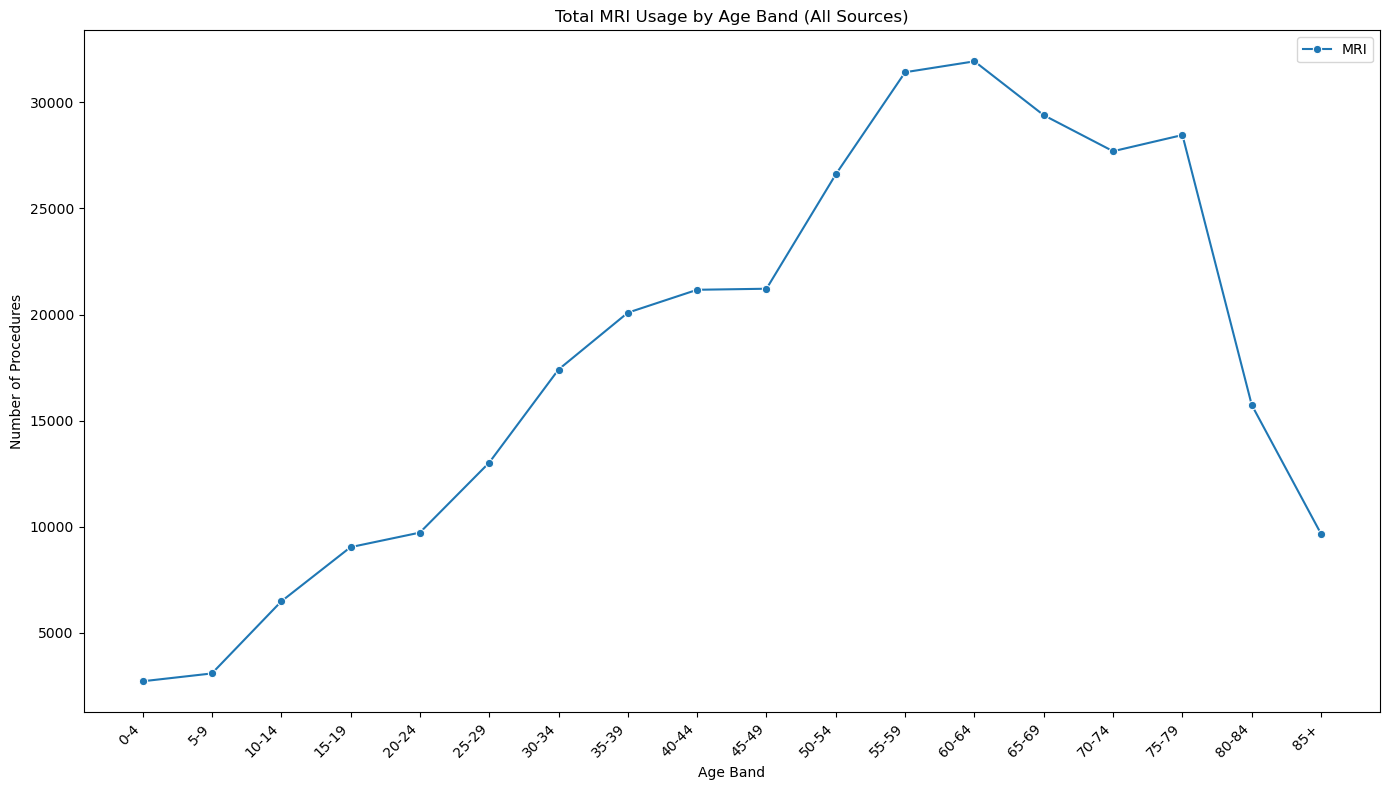

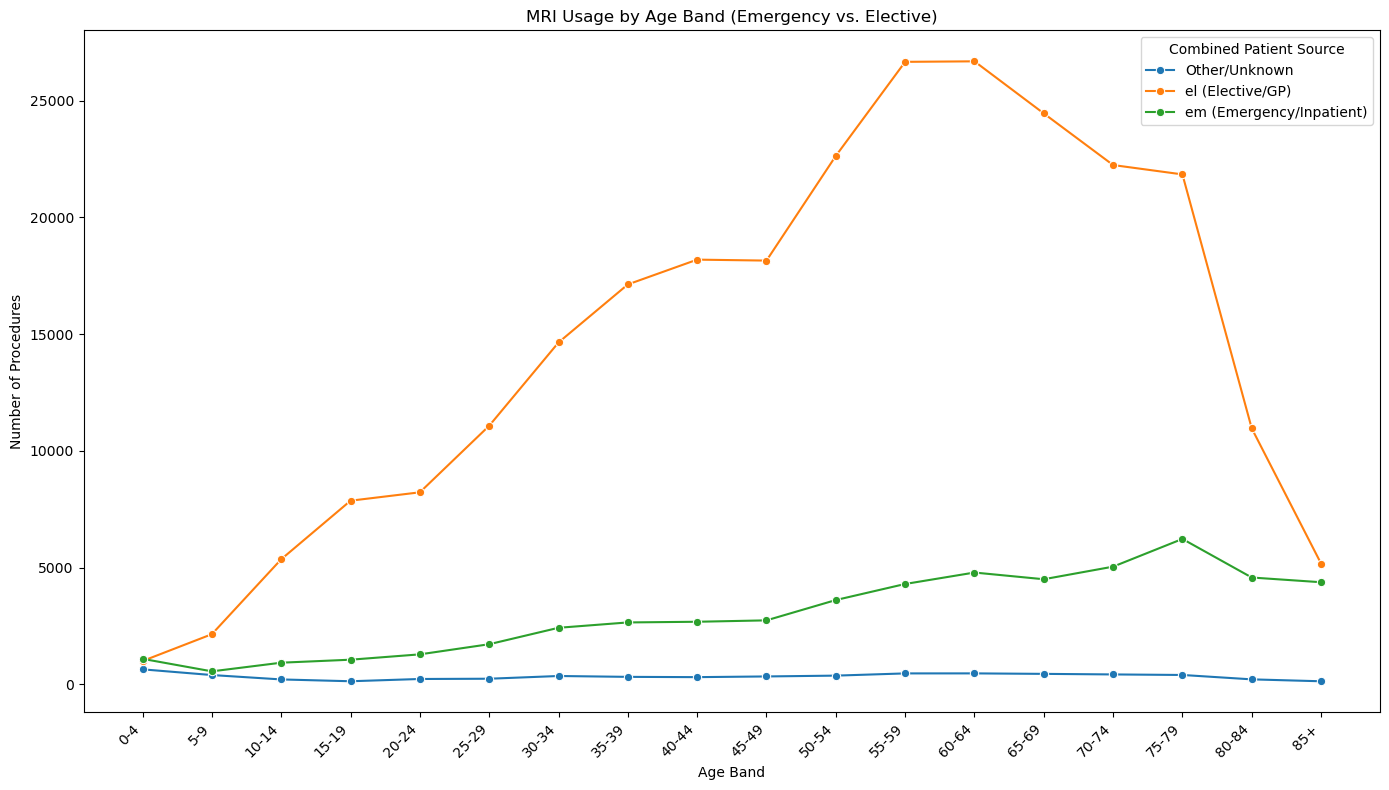

--- Generating Plots for Endoscopy ---


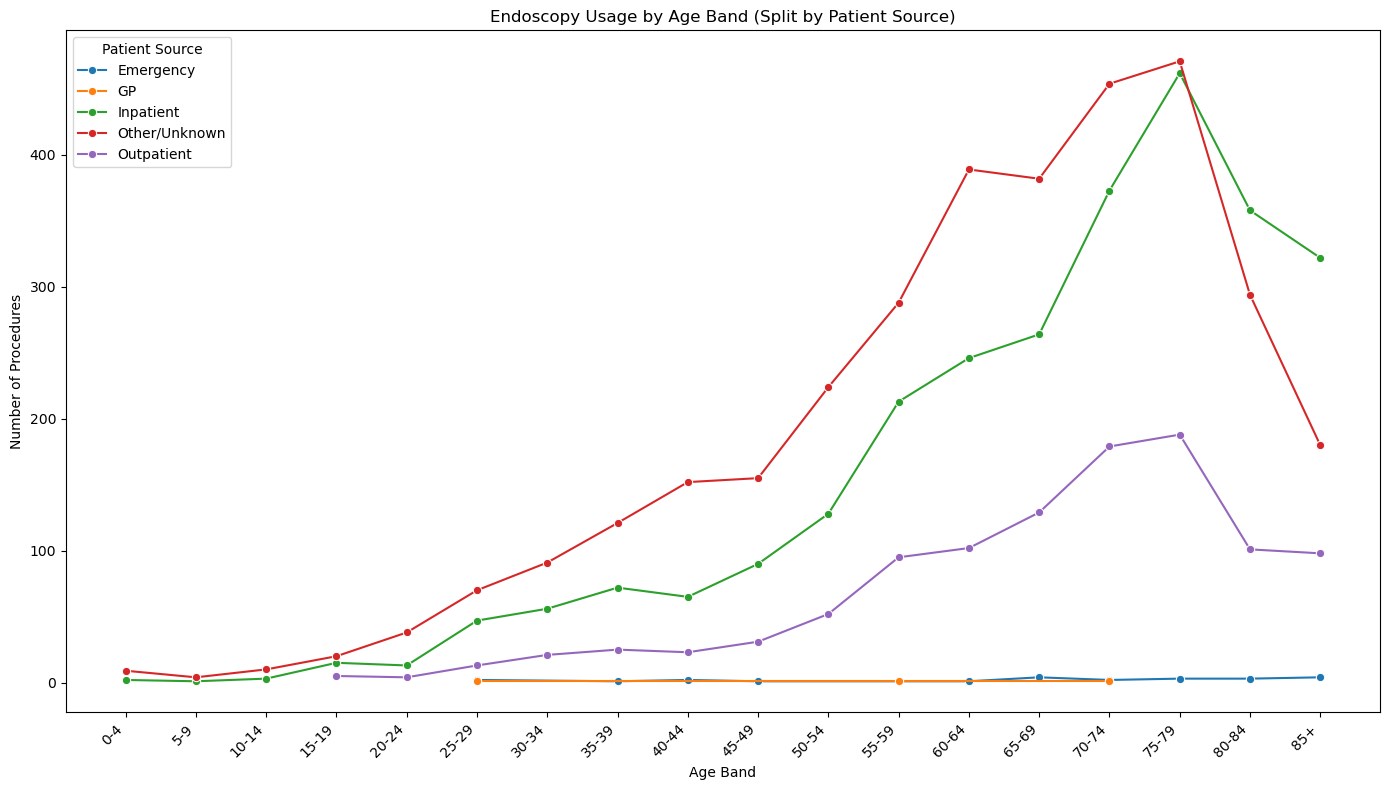

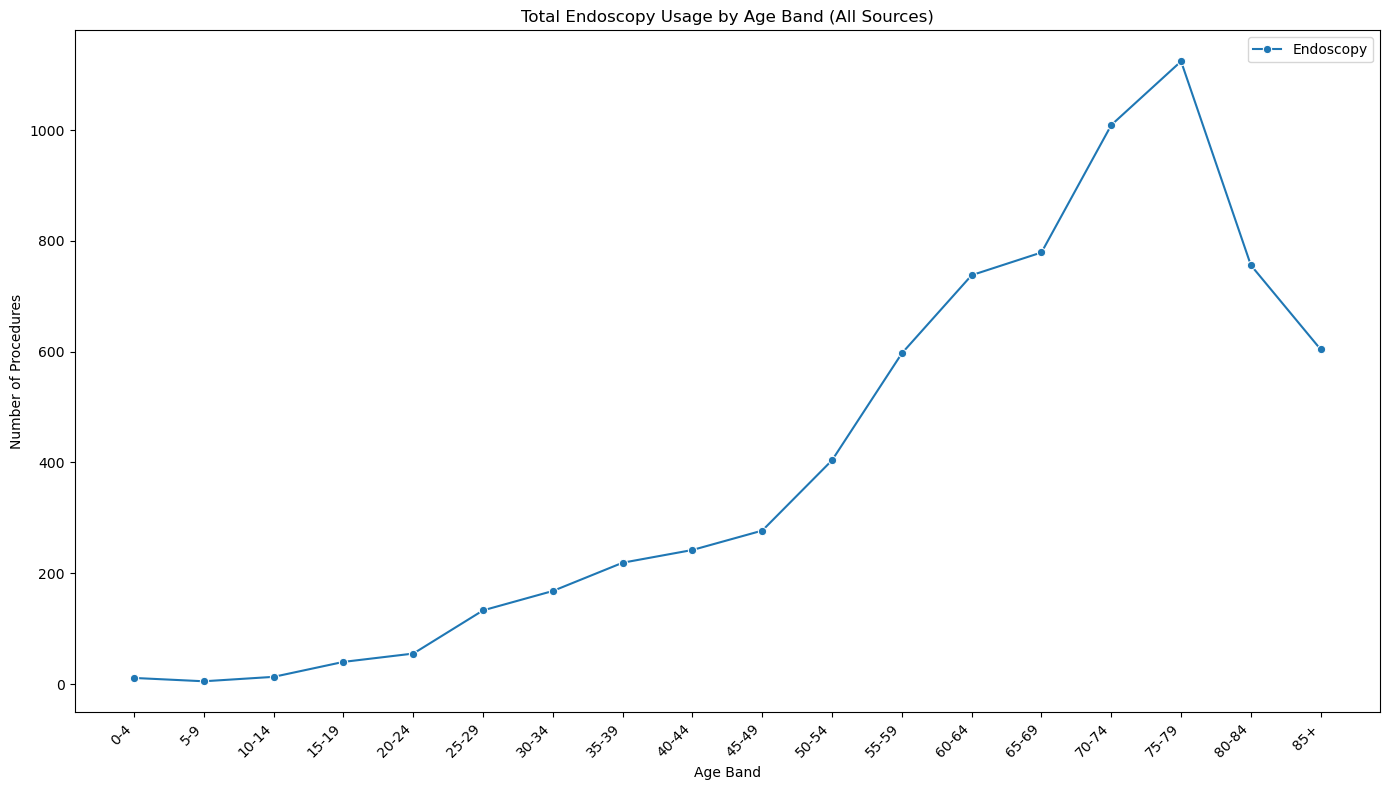

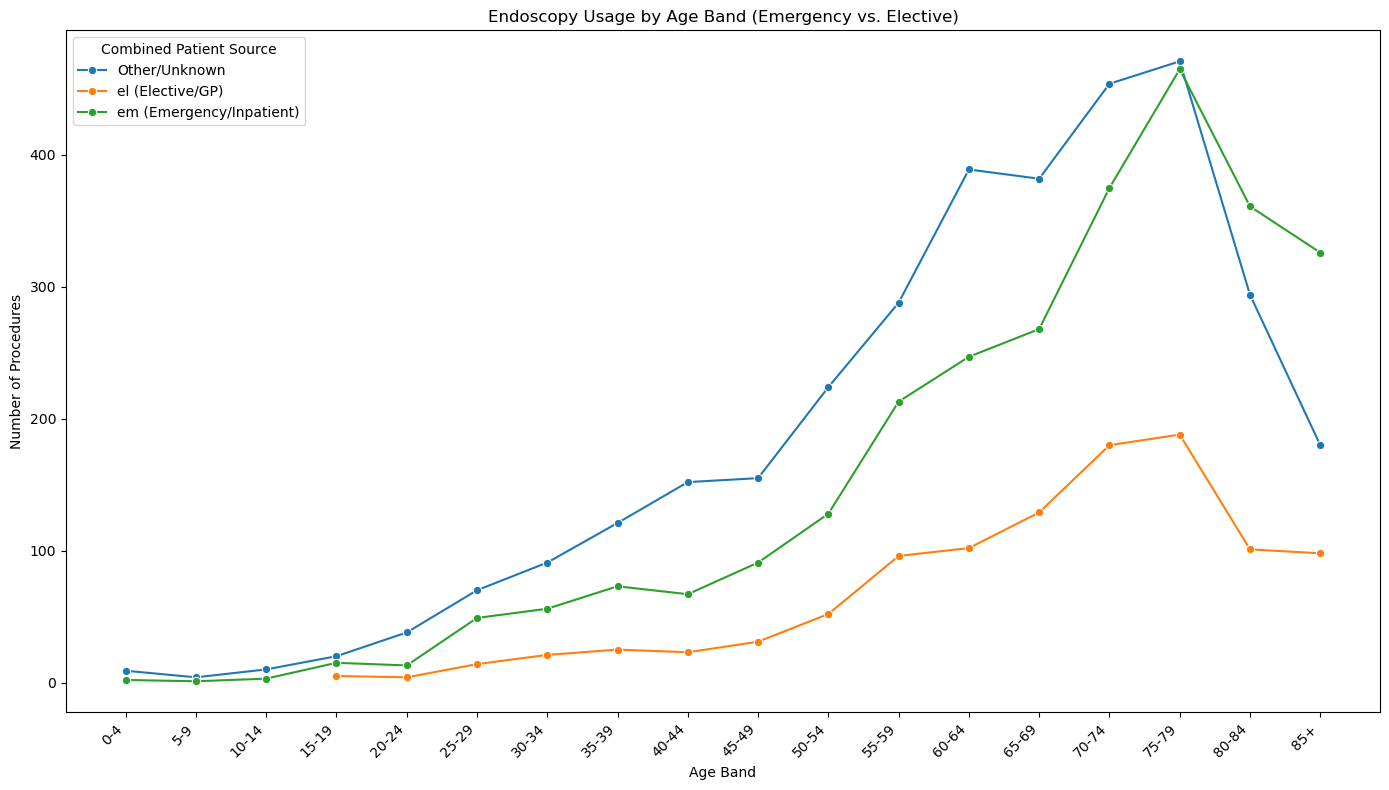

In [4]:
# Generate plots for your specified modality buckets
if 'df' in locals() and not df.empty:
    # You can customize this list to plot other buckets like 'Radiography' or 'Ultrasound'
    modality_buckets_to_plot = ['CT', 'MRI', 'Endoscopy']
    
    available_buckets = df['modality_bucket'].unique()
    
    for bucket in modality_buckets_to_plot:
        if bucket in available_buckets:
            plot_modality_usage(df, bucket)
        else:
            print(f"Modality bucket '{bucket}' not found in the dataset.")
else:
    print("DataFrame 'df' is not available or is empty. Cannot generate plots.")